In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import importlib

# Add code directory to path
sys.path.insert(0, r'C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code')

# Force reload to get latest changes
if 'DiffLenExt' in sys.modules:
    importlib.reload(sys.modules['DiffLenExt'])
if 'perpendicular' in sys.modules:
    importlib.reload(sys.modules['perpendicular'])

from DiffLenExt import DiffusionLengthExtractor
from perpendicular import gradient_with_window

print("Imports successful!")


Imports successful!


In [2]:
# Set up paths
data_dir = Path(r'C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\perpendicular_plots\25B2_P4_80kx_30um')
vb_input = "02,0,06"
profile_input = "1,5,8,13"
# -------------------------------------------

# Parse VB tokens into filename substrings (case-insensitive)
vb_tokens = [t.strip() for t in vb_input.split(',') if t.strip()]
vb_patterns = []
for t in vb_tokens:
    tt = t.lower()
    if tt in ('0', 'novb', 'no', 'n'):           # treat as noVb
        vb_patterns.append('novb')
    elif tt.startswith('vb'):                     # user passed "VB02" or "vb02"
        num = tt[2:]
        vb_patterns.append('vb' + num)
        vb_patterns.append('vb' + num.zfill(2))
    else:                                         # numeric like "2","02","08"
        vb_patterns.append('vb' + tt)             # vb2
        vb_patterns.append('vb' + tt.zfill(2))    # vb02

# Parse profile numbers into filename substrings
profile_tokens = [p.strip() for p in profile_input.split(',') if p.strip()]
profile_patterns = []
for p in profile_tokens:
    try:
        n = int(p)
        profile_patterns.append(f"profile_{n:02d}")
    except ValueError:
        # if user typed the full substring already, accept it
        profile_patterns.append(p.lower())

# Collect and filter CSV files (case-insensitive match)
all_csv = sorted(list(data_dir.glob('*.csv')))
csv_files = []
for f in all_csv:
    name_l = f.name.lower()
    if any(v in name_l for v in vb_patterns) and any(p in name_l for p in profile_patterns):
        csv_files.append(f)

print(f"Found {len(csv_files)} CSV files matching VB={vb_input} profiles={profile_input}")
for f in csv_files:
    print(f"  {f.name}")

Found 12 CSV files matching VB=02,0,06 profiles=1,5,8,13
  25B2_P4_80kx_30um_noVb_profile_01.csv
  25B2_P4_80kx_30um_noVb_profile_05.csv
  25B2_P4_80kx_30um_noVb_profile_08.csv
  25B2_P4_80kx_30um_noVb_profile_13.csv
  25B2_P4_80kx_30um_Vb02_profile_01.csv
  25B2_P4_80kx_30um_Vb02_profile_05.csv
  25B2_P4_80kx_30um_Vb02_profile_08.csv
  25B2_P4_80kx_30um_Vb02_profile_13.csv
  25B2_P4_80kx_30um_Vb06_profile_01.csv
  25B2_P4_80kx_30um_Vb06_profile_05.csv
  25B2_P4_80kx_30um_Vb06_profile_08.csv
  25B2_P4_80kx_30um_Vb06_profile_13.csv


In [3]:
# Load a single profile for testing
test_file = csv_files[0]  # Change index to test different profiles
print(f"Loading: {test_file.name}")

df = pd.read_csv(test_file)
print(f"\nColumns: {df.columns.tolist()}")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Loading: 25B2_P4_80kx_30um_noVb_profile_01.csv

Columns: ['distance_um', 'sem_raw', 'sem_normalized', 'current_nA', 'current_log_safe', 'is_junction']
Shape: (138, 6)

First few rows:


,distance_um,sem_raw,sem_normalized,current_nA,current_log_safe,is_junction
0,-0.250000,10654.530481,0.409514,0.175942,0.175942,No
1,-0.246350,10944.745546,0.447056,0.226613,0.226613,No
2,-0.242701,12084.889150,0.594543,0.197928,0.197928,No
3,-0.239051,12375.789316,0.632174,0.231344,0.231344,No
4,-0.235401,11964.024614,0.578909,0.182093,0.182093,No


In [4]:
# Extract data
x_vals = df['distance_um'].values
y_vals = df['current_nA'].values

# Find junction index
junction_idx = df[df['is_junction'] == 'Yes'].index
if len(junction_idx) > 0:
    junction_idx = junction_idx[0]
else:
    # Find maximum current as junction
    junction_idx = np.argmax(y_vals)

print(f"Junction index: {junction_idx}")
print(f"Junction position: {x_vals[junction_idx]:.3f} µm")
print(f"Current range: {y_vals.min():.3e} to {y_vals.max():.3e} nA")

Junction index: 67
Junction position: -0.005 µm
Current range: 4.603e-02 to 2.422e+01 nA


Forced junction index at x=0 -> idx: 68, position: -0.001825 µm


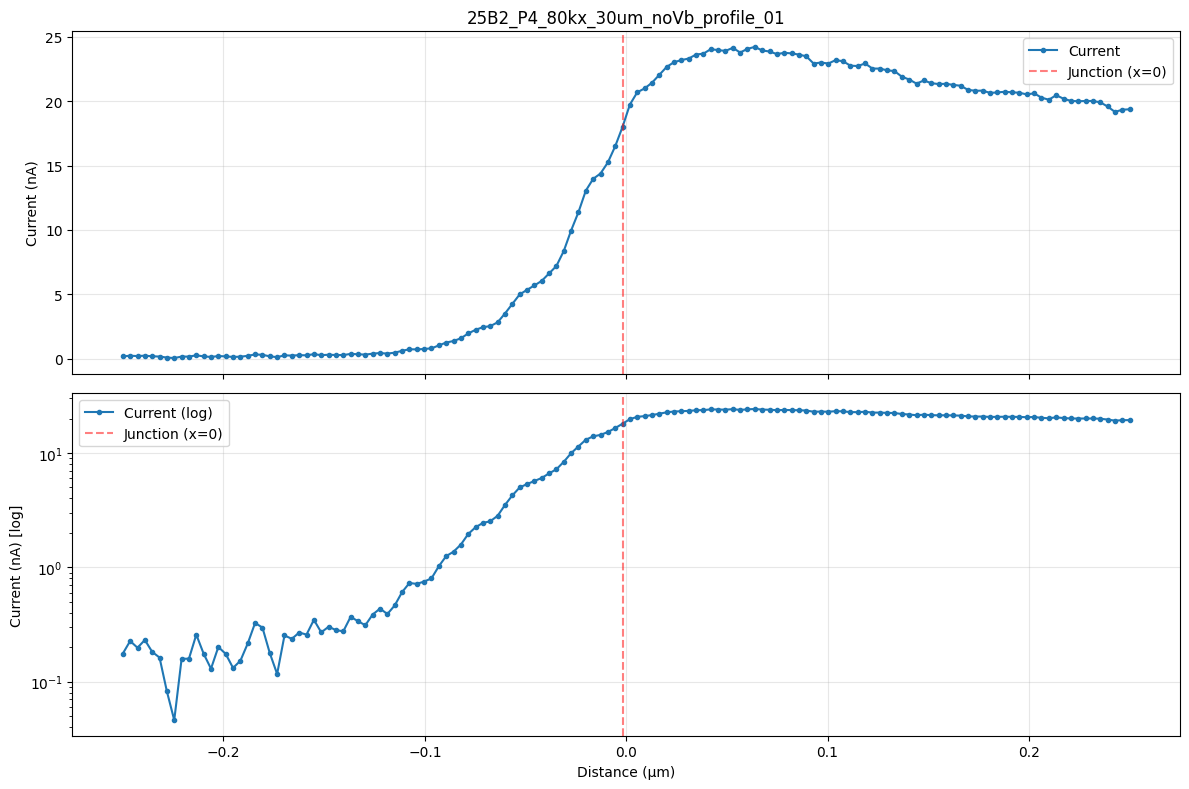

In [5]:
# Force junction to x = 0 (choose the index closest to 0)
junction_idx = int(np.argmin(np.abs(x_vals - 0.0)))
print(f"Forced junction index at x=0 -> idx: {junction_idx}, position: {x_vals[junction_idx]:.6f} µm")

# Plot the raw data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Linear scale
ax1.plot(x_vals, y_vals, 'o-', markersize=3, label='Current')
ax1.axvline(x_vals[junction_idx], color='red', linestyle='--', alpha=0.5, label='Junction (x=0)')
ax1.set_ylabel('Current (nA)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title(f'{test_file.stem}')

# Log scale
pos = y_vals[y_vals > 0]
floor = max(np.min(pos) * 0.1, 1e-12) if pos.size > 0 else 1e-12
y_safe = np.maximum(y_vals, floor)
ax2.plot(x_vals, y_safe, 'o-', markersize=3, label='Current (log)')
ax2.axvline(x_vals[junction_idx], color='red', linestyle='--', alpha=0.5, label='Junction (x=0)')
ax2.set_yscale('log')
ax2.set_xlabel('Distance (µm)')
ax2.set_ylabel('Current (nA) [log]')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Function to fit and plot multiple profiles with adjustable parameters
def fit_and_plot_profiles(csv_files, params):
    """
    Fit linear models to multiple perpendicular profiles.
    
    Args:
        csv_files: List of CSV file paths to process
        params: Dictionary of fitting parameters
    
    Returns:
        List of extractor objects (one per file)
    """
    extractors = []
    pixel_size = 1e-6  # 1 µm
    
    for csv_file in csv_files:
        # Load data
        df = pd.read_csv(csv_file)
        x_vals = df['distance_um'].values
        y_vals = df['current_nA'].values
        
        # Find junction index (closest to x=0)
        junction_idx = int(np.argmin(np.abs(x_vals - 0.0)))
        
        # Create profile dict
        profile = {
            'id': 0,
            'dist_um': x_vals,
            'sem': df['sem_raw'].values,
            'current': y_vals,
            'intersection_idx': junction_idx,
            'source_name': csv_file.name
        }
        
        # Initialize extractor and load profile
        extractor = DiffusionLengthExtractor(pixel_size, smoothing_sigma=1)
        extractor.load_profiles([profile])
        
        # Run fitting
        extractor.fit_all_profiles_linear(**params)
        
        # Plot results
        plot_fitting_results(extractor, csv_file.name)
        
        extractors.append(extractor)
    
    return extractors


def plot_fitting_results(extractor, filename):
    """
    Plot fitting results for a single profile.
    EXACT copy from helper_gui.py plotting function.
    """
    if not extractor.results:
        print("No results to plot")
        return
    
    res = extractor.results[0]
    profile_idx = res.get('Profile', 1)
    depletion = res.get('depletion', {})
    best_left = depletion.get('best_left_fit')
    best_right = depletion.get('best_right_fit')
    
    left_slope = best_left.get('slope') if best_left is not None else None
    left_r2 = best_left.get('r2') if best_left is not None else None
    right_slope = best_right.get('slope') if best_right is not None else None
    right_r2 = best_right.get('r2') if best_right is not None else None
    left_start = depletion.get('left_start')
    right_start = depletion.get('right_start')
    depletion_width = depletion.get('depletion_width')
    
    # Extract profile data
    profile_entry = extractor.profiles[profile_idx - 1]
    x = np.array(profile_entry.get('dist_um', []), dtype=float)
    y = np.array(profile_entry.get('current', []), dtype=float)
    
    # Center x axis at the detected junction
    intersection_idx = profile_entry.get('intersection_idx', None)
    if intersection_idx is not None and 0 <= int(intersection_idx) < len(x):
        ref = float(x[int(intersection_idx)])
        base_idx = int(intersection_idx)
    else:
        base_idx = int(np.argmax(y))
        ref = float(x[base_idx])
    
    # Build ln(current) from raw data
    pos = y[y > 0]
    floor = max(np.min(pos) * 0.1, 1e-12) if pos.size > 0 else 1e-12
    y_safe = np.maximum(y, floor)
    ln_y = np.log(y_safe)
    
    # Compute filtered signal (used internally for fits) and its ln
    try:
        y_filtered = extractor.apply_low_pass_filter(y, visualize=False)
        y_filtered_safe = np.maximum(y_filtered, floor)
        ln_y_filtered = np.log(y_filtered_safe)
    except Exception:
        y_filtered = None
        ln_y_filtered = None
    
    # Create a 2-row figure: top = ln(Current) and fits, bottom = derivatives
    fig, (ax, ax_der) = plt.subplots(2, 1, sharex=True, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1]})
    x_plot = x - ref
    
    # Plot raw ln(Current)
    ax.plot(x_plot, ln_y, 'k.-', label='ln(Current) (raw)')
    
    # Plot filtered ln(Current) if available (smooth line)
    if ln_y_filtered is not None:
        ax.plot(x_plot, ln_y_filtered, color='tab:orange', lw=1.8, alpha=0.9, label='ln(Current) (filtered)')
    
    # Overlay best-left/right fits
    if best_left is not None:
        if 'global_x_vals' in best_left:
            x_fit = np.array(best_left['global_x_vals'], dtype=float) - ref
            if 'ln_fit_curve' in best_left:
                y_fit = np.array(best_left['ln_fit_curve'], dtype=float)
            else:
                y_fit = np.log(np.maximum(np.array(best_left.get('fit_curve', [])), floor))
        else:
            x_fit = -np.array(best_left.get('x_vals', []), dtype=float) - ref
            y_fit = np.array(best_left.get('slope', 0.0)) * np.array(best_left.get('x_vals', []), dtype=float) + best_left.get('intercept', 0.0)
        ax.plot(x_fit, y_fit, 'b-', lw=2.0, label=f"Left fit (s={left_slope:.3g}, R²={left_r2:.2f})")
        if left_start is not None:
            ax.axvline(left_start - ref, color='b', linestyle='--')
    
    if best_right is not None:
        if 'global_x_vals' in best_right:
            x_fit = np.array(best_right['global_x_vals'], dtype=float) - ref
            if 'ln_fit_curve' in best_right:
                y_fit = np.array(best_right['ln_fit_curve'], dtype=float)
            else:
                y_fit = np.log(np.maximum(np.array(best_right.get('fit_curve', [])), floor))
        else:
            x_fit = np.array(best_right.get('x_vals', []), dtype=float) - ref
            y_fit = np.array(best_right.get('slope', 0.0)) * np.array(best_right.get('x_vals', []), dtype=float) + best_right.get('intercept', 0.0)
        ax.plot(x_fit, y_fit, 'r-', lw=2.0, label=f"Right fit (s={right_slope:.3g}, R²={right_r2:.2f})")
        if right_start is not None:
            ax.axvline(right_start - ref, color='r', linestyle='--')
    
    # Shade depletion region
    if left_start is not None and right_start is not None:
        ax.axvspan(left_start - ref, right_start - ref, color='green', alpha=0.12)
    
    # Highlight detected plateau regions (if available)
    if best_left is not None and 'plateau_indices' in best_left:
        idx_start, idx_end = best_left['plateau_indices']
        if idx_start < len(x) and idx_end <= len(x):
            plat_x_start = x[idx_start] - ref
            plat_x_end = x[idx_end - 1] - ref
            ax.axvspan(plat_x_start, plat_x_end, color='blue', alpha=0.08, label='Left plateau region')
    
    if best_right is not None and 'plateau_indices' in best_right:
        idx_start, idx_end = best_right['plateau_indices']
        if idx_start < len(x) and idx_end <= len(x):
            plat_x_start = x[idx_start] - ref
            plat_x_end = x[idx_end - 1] - ref
            ax.axvspan(plat_x_start, plat_x_end, color='red', alpha=0.08, label='Right plateau region')
    
    ax.set_xlabel('Distance (µm)')
    ax.set_ylabel('ln(Current)')
    ax.set_title(f"{filename}\nDepletion width = {depletion_width if depletion_width is not None else float('nan'):.3g} µm")
    ax.legend(fontsize='small')
    ax.grid(True, linestyle='--', alpha=0.4)
    
    # --- Derivative panel: d(lnI)/dx ---
    gradient_window = extractor.plateau_params.get('gradient_window', 9)
    try:
        x_vals_plot = np.array(x_plot, dtype=float)
        if x_vals_plot.size > 1:
            source_ln = ln_y
            dln_meas = gradient_with_window(x_vals_plot, source_ln, window=gradient_window)
        else:
            dln_meas = np.zeros_like(x_vals_plot)
    except Exception:
        dln_meas = np.zeros_like(x_plot)
    
    ax_der.plot(x_plot, dln_meas, color='tab:gray', linestyle=':', label='dlnI/dx (meas)')
    
    # Overlay fit-derived dlnI/dx when available
    try:
        def _get_fit_derivative_mapped(fit_dict, side):
            if fit_dict is None:
                return None, None
            if 'global_x_vals' in fit_dict:
                fx = np.array(fit_dict['global_x_vals'], dtype=float) - ref
            elif 'global_x' in fit_dict:
                fx = np.array(fit_dict['global_x'], dtype=float) - ref
            else:
                if side == 'Left':
                    fx = -np.array(fit_dict.get('x_vals', []), dtype=float) - ref
                else:
                    fx = np.array(fit_dict.get('x_vals', []), dtype=float) - ref
            
            if 'fit_dlnI_dx' in fit_dict:
                fdln = np.array(fit_dict['fit_dlnI_dx'], dtype=float)
            else:
                fc = np.array(fit_dict.get('fit_curve', []), dtype=float)
                if fx.size > 1 and fc.size == fx.size:
                    try:
                        fdln = gradient_with_window(fx + ref, np.log(np.maximum(fc, 1e-12)), window=gradient_window)
                    except Exception:
                        fdln = None
                else:
                    fdln = None
            return fx, fdln
        
        left_fx, left_fdln = _get_fit_derivative_mapped(best_left, 'Left')
        right_fx, right_fdln = _get_fit_derivative_mapped(best_right, 'Right')
        
        if left_fx is not None and left_fdln is not None:
            si = np.argsort(left_fx)
            lf = left_fx[si]
            ld = left_fdln[si]
            ax_der.plot(lf, ld, 'b-', lw=1.6, label='dlnI/dx (left fit)')
        
        if right_fx is not None and right_fdln is not None:
            si = np.argsort(right_fx)
            rf = right_fx[si]
            rd = right_fdln[si]
            ax_der.plot(rf, rd, 'r-', lw=1.6, label='dlnI/dx (right fit)')
    except Exception as e:
        print(f"Error plotting derivatives: {e}")
    
    ax_der.set_xlabel('Distance (µm)')
    ax_der.set_ylabel('dlnI/dx (1/µm)')
    ax_der.grid(True, linestyle='--', alpha=0.4)
    ax_der.legend(fontsize='small')
    
    fig.tight_layout()
    plt.show()

print("Functions defined successfully!")


Functions defined successfully!


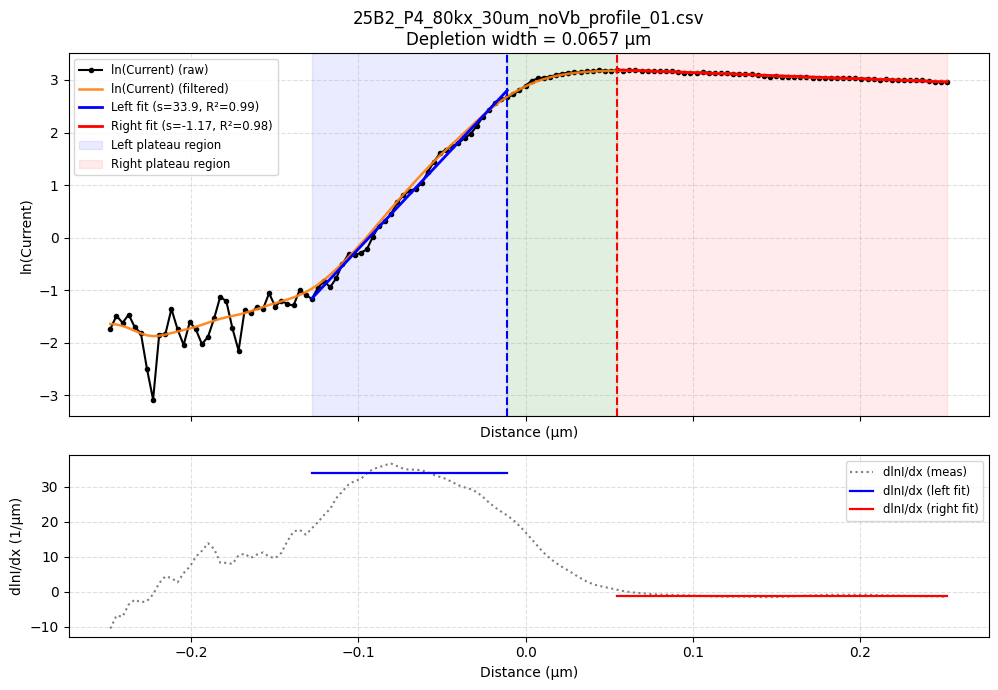

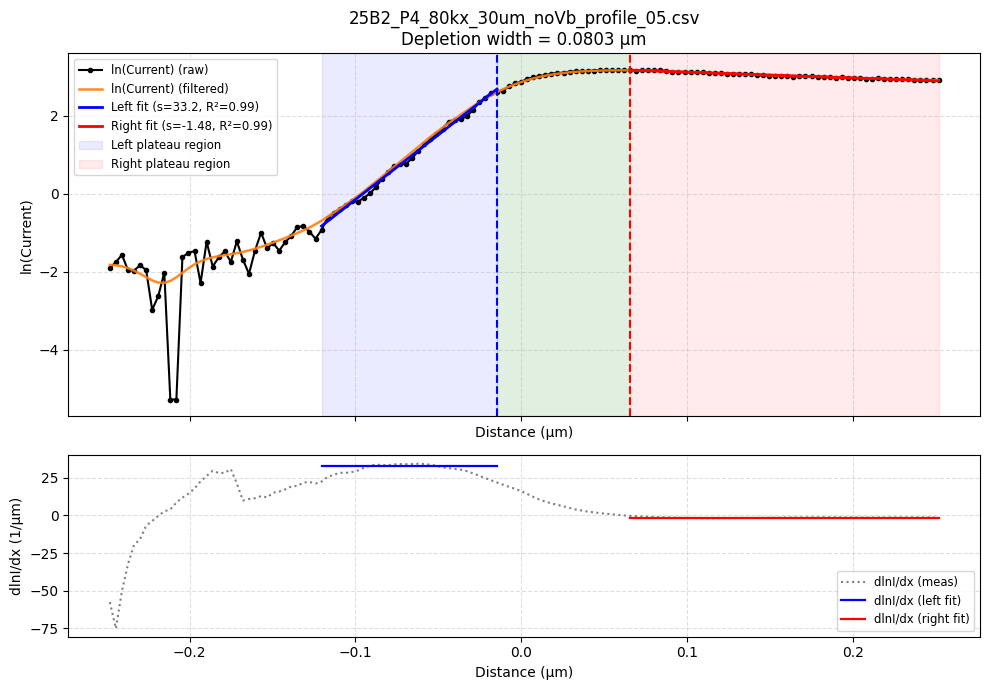

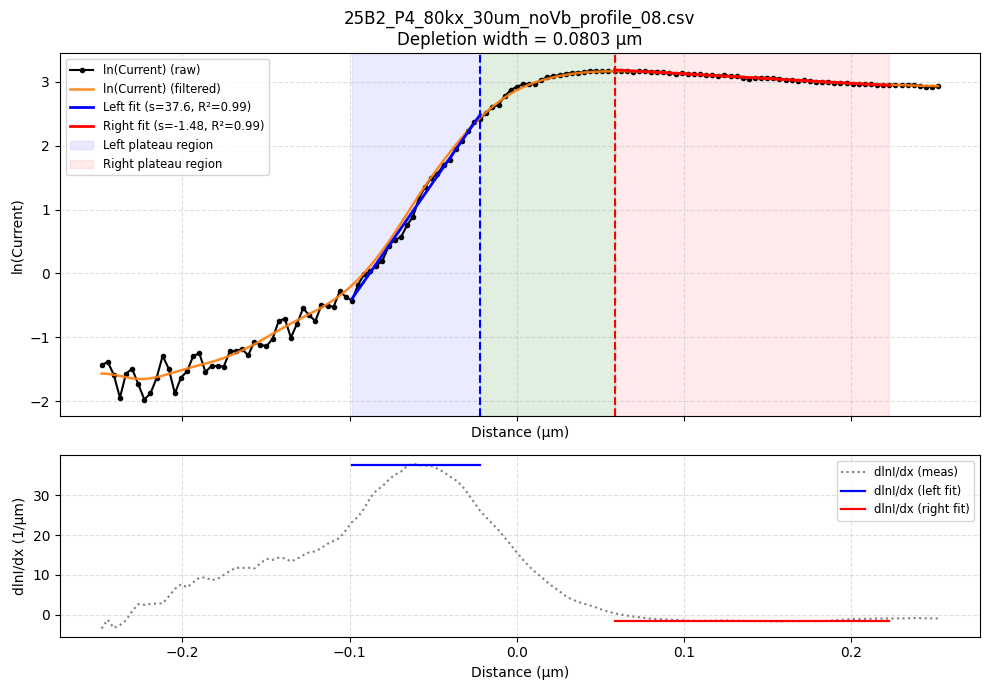

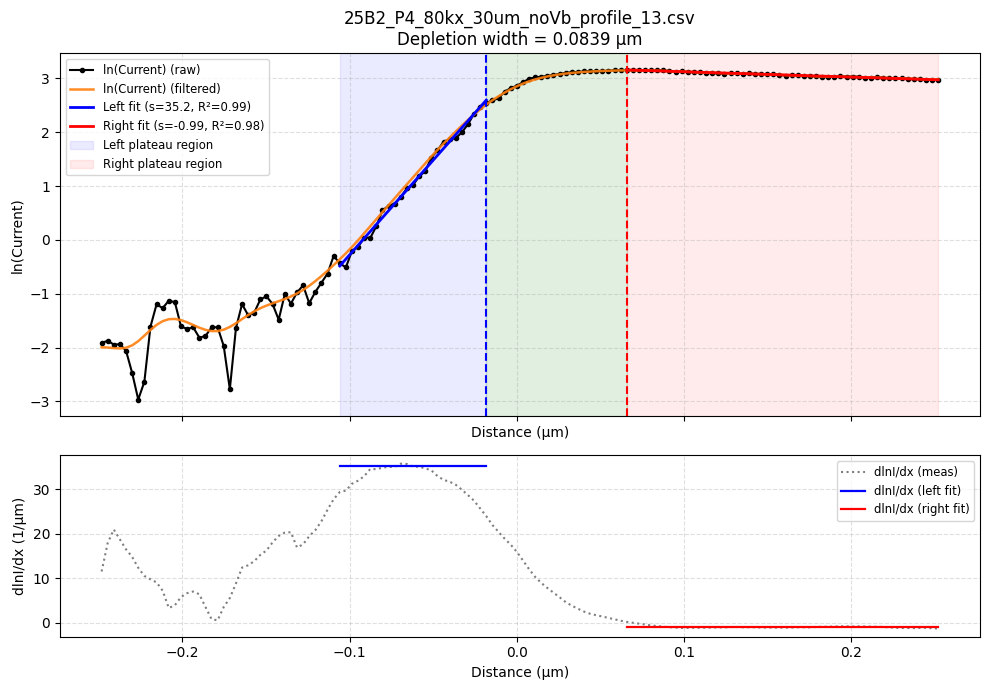

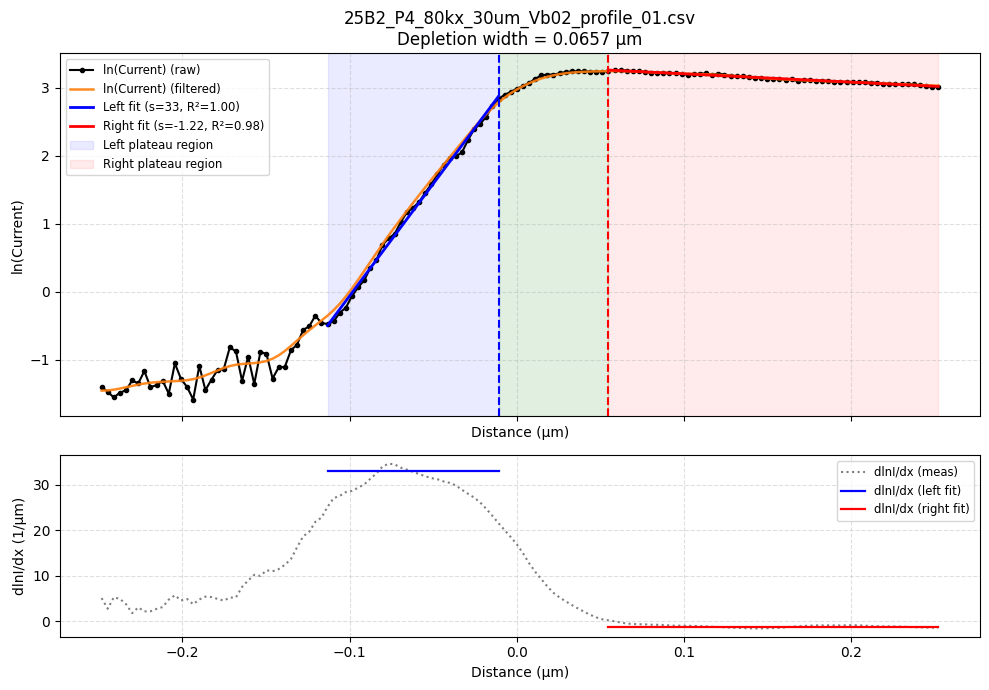

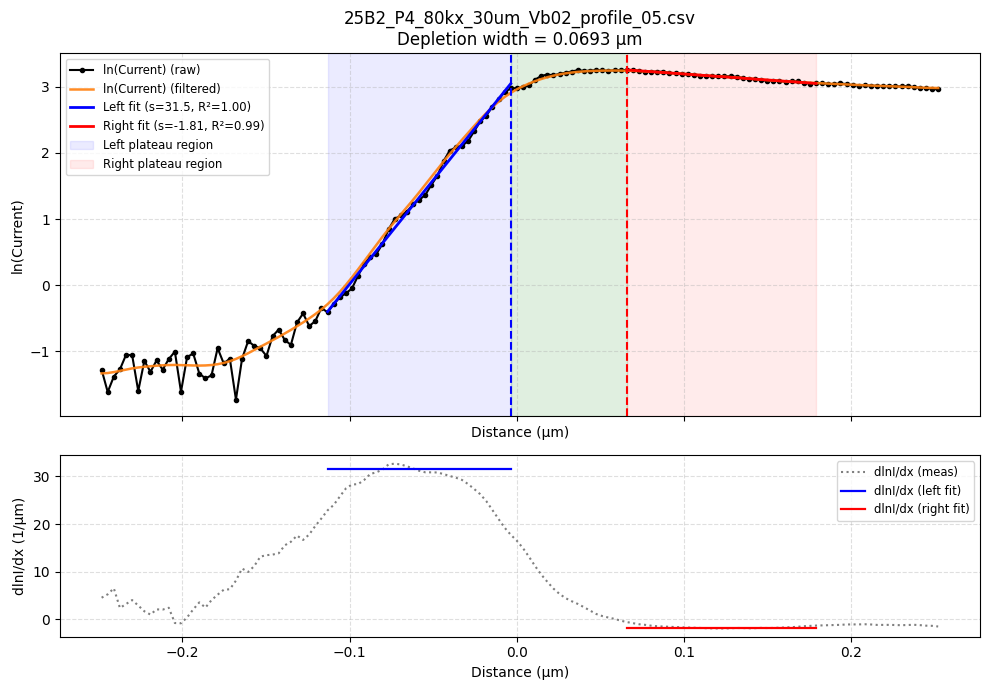

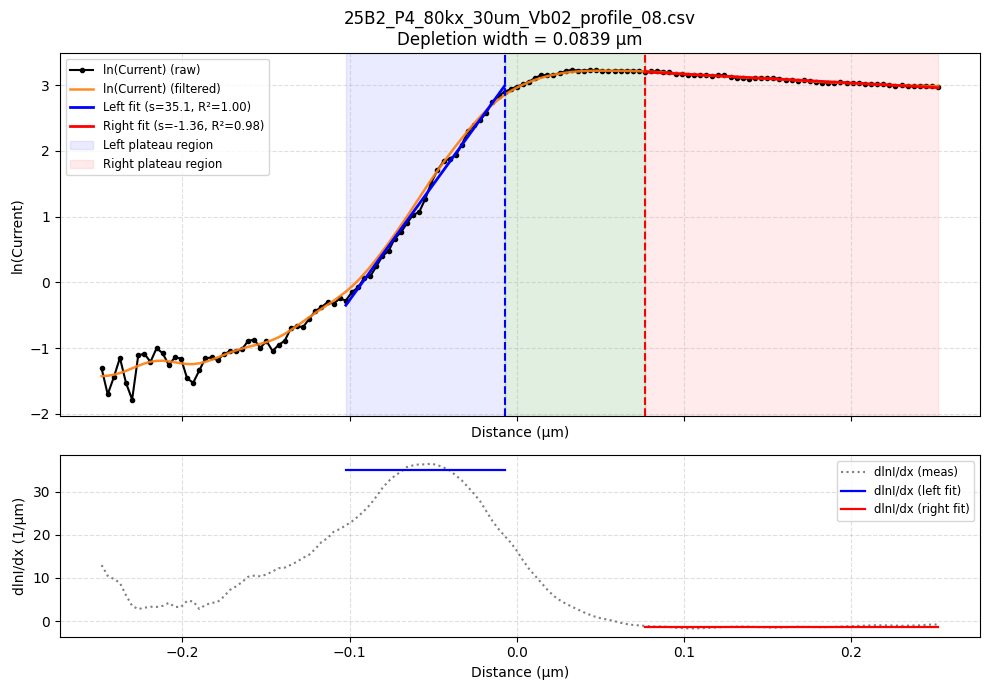

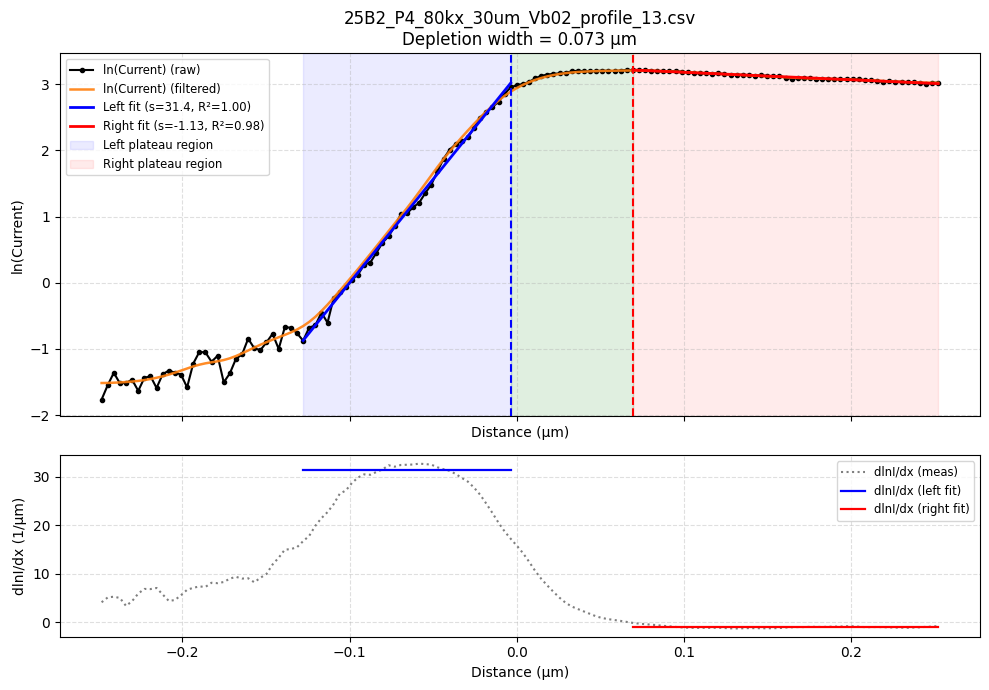

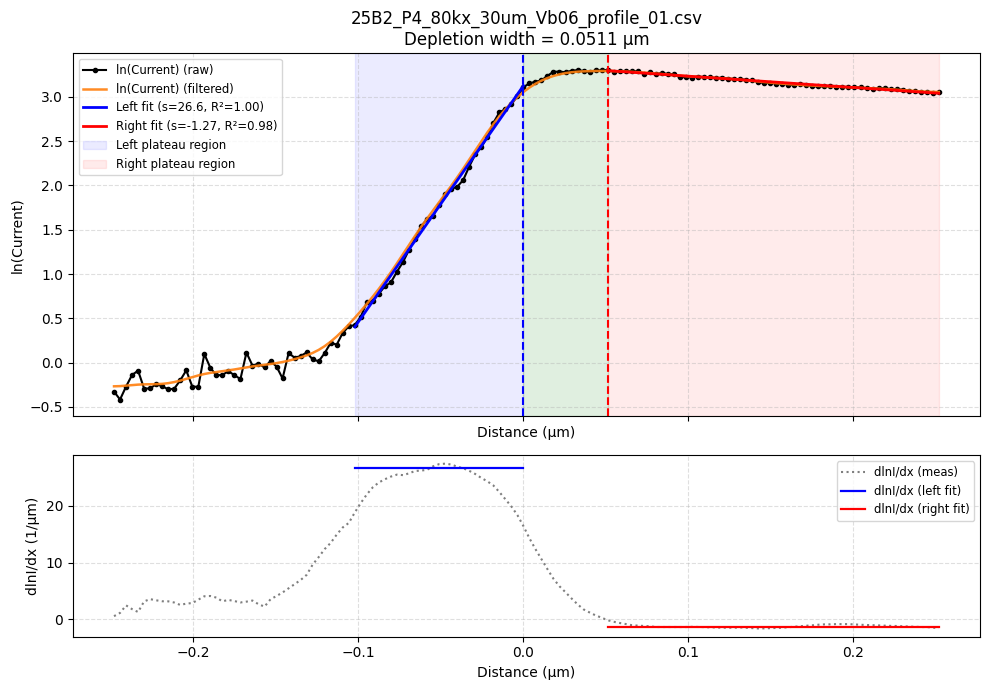

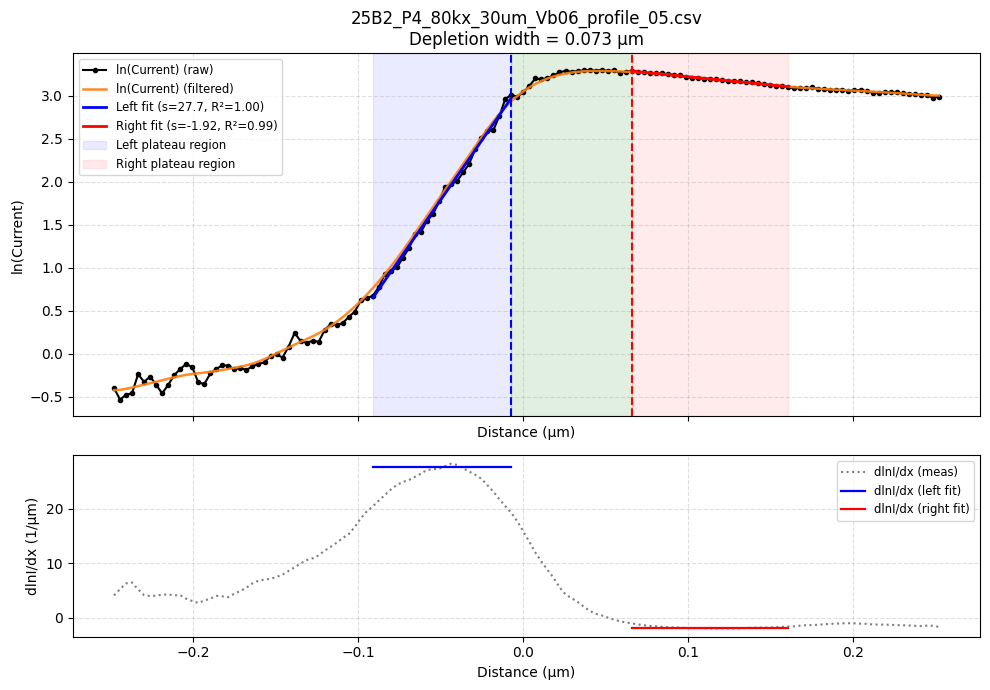

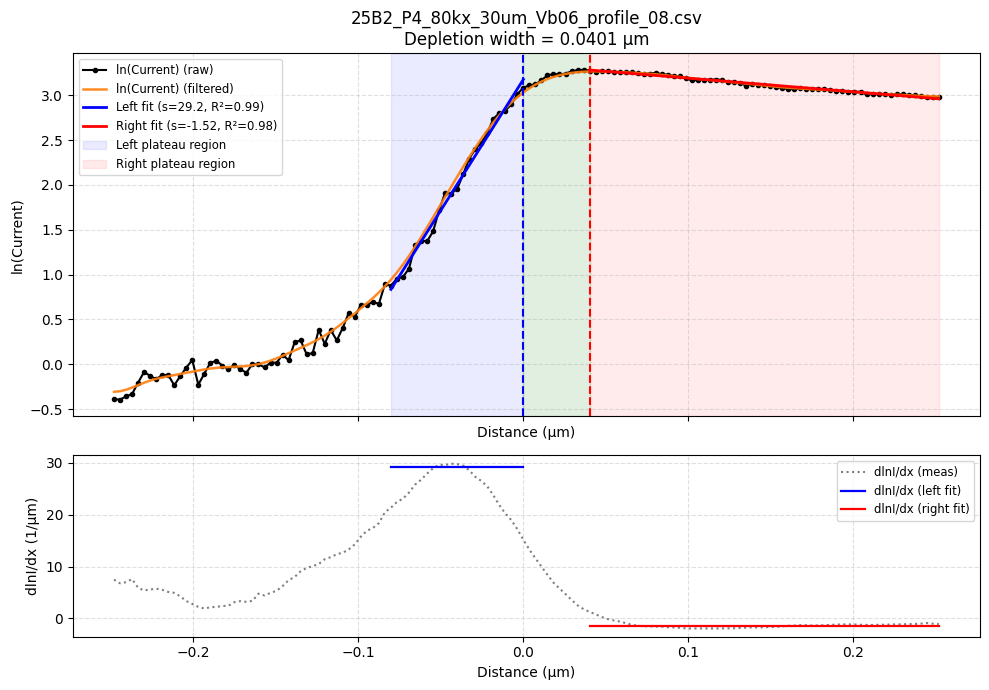

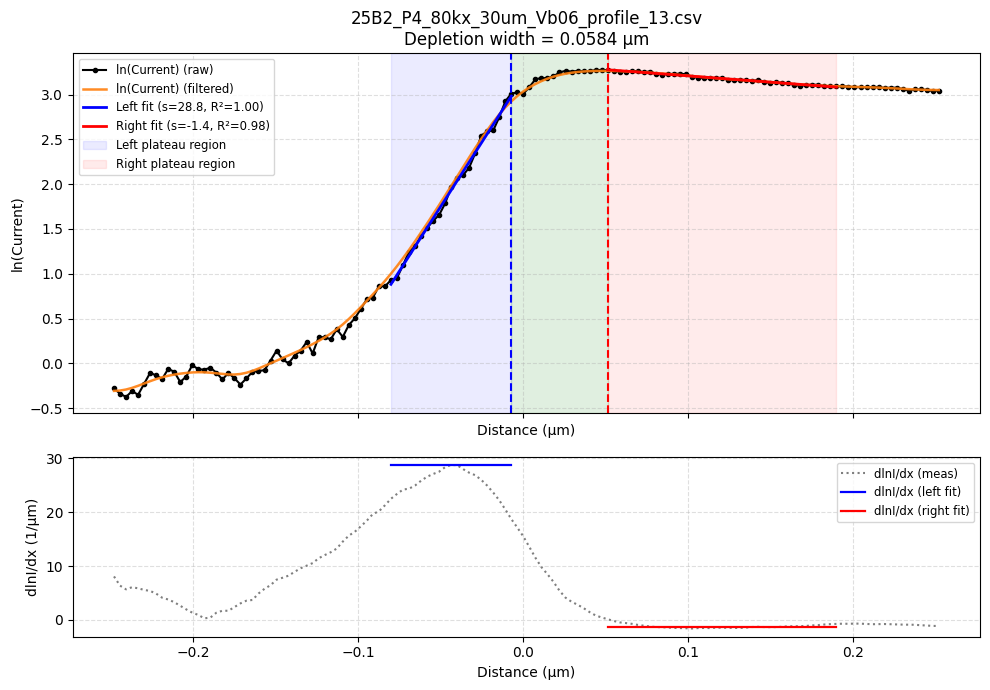


Completed processing 12 profiles


In [7]:
# ============================================
# ADJUST PARAMETERS HERE
# ============================================

params = {
    'use_plateau_detection': True,   # Use derivative plateau method
    'use_shifting': True,             # Enable iterative expansion
    'gradient_window': 21,             # Window size for derivative
    'min_plateau_length': 7,          # Minimum plateau size
    'derivative_threshold': 0.10,     # Max relative variation in derivative
    'absolute_threshold': 0.03,       # Max absolute variation (1/µm)
    'max_expansion': 1000,            # Max pixels to expand beyond plateau
    'consecutive_drops': 20,          # Stop after N consecutive R² drops
    'junction_precision': False        # Start from junction to detect linearity onset
}

# Run fitting for all selected profiles
extractors = fit_and_plot_profiles(csv_files, params)

print(f"\n{'='*60}")
print(f"Completed processing {len(extractors)} profiles")
print('='*60)


## Compare Different Voltages or Profiles
Change `VOLTAGE` and `PROFILE_NUMBER` in the second cell and re-run to test different conditions.